# Bee Population & Economic Pricing in the US Report

Results presented by Madeline Rosenberg

In [1]:
###This tagged code was very helpful in recovering unintentionally changed portions of the code.
###I left this in because the reference deserves to be here with how much time it and troubles it saved
#%history -g -f 'FinalProject.ipynb'
##########reference: https://stackoverflow.com/questions/48373577/recovering-command-history-in-jupyter-notebook

# --------------------------------------------------------

# INSTRUCTIONS TO RUN CODE:

Code will not run unless you:
1. request a username and password from https://docs.quandl.com/docs/in-depth-usage
2. create a passwords.csv file with the API key
3. change the variable source_dir to represent your directory path

# --------------------------------------------------------

## Quandl API and Caching

The purpose of this is to get Quandl API data and cache it as a Json. I can get 50000 API calls per day.

In [15]:
######################################Instructions:#########################################################################
###############Only run this line if your Anaconda does not have requests_cache installed already
############################################################################################################################

##Note: must already have conda to run
##      may need to copy code to terminal
#conda install -c conda-forge requests-cache 

################################Reference:#######################################
##################references: https://anaconda.org/conda-forge/requests_cache
#################################################################################

In [4]:
with open("passwords.csv") as myfile:
    password =next(myfile)

In [55]:
################Credit: Jordan Hemingway helped debug API request/API limit issues and recommended requests_cache. In addition, recommended time.sleep() (import time)###############
#########################Purpose of this code block: establish imports and important variables. Explanations of variables are next to the variables themselves.
import requests
import json
import requests_cache
import os
import json
import time ###very helpful recommendation from Jordan. Reduce number of API requests at once with time.sleep()
from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
requests_cache.install_cache('econdb_cache') ######this line initiallizes the cache with requests-cache module, prevents calling the API over and over
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import matplotlib.ticker as plticker ###this locator puts ticks at regular intervals
import matplotlib.dates as mdates 
import re

##opening API key file


%matplotlib inline 
base_url = 'http://www.quandl.com/api/v3/datasets/{}?api_key=' +password ##JOB RECRUITERS: ASK ME FOR THE API KEY
datanames_lst = ['ODA/PROIL_USD', 'ODA/PCOFFOTM_USD', 'ODA/PCOFFROB_USD', 'ODA/PCOCO_USD', 'ODA/PTEA_USD', 'ODA/PCOPP_USD'] #list of the commodity codes that will be obtained from the API. 
source_dir = os.path.dirname("/Users/bd/Desktop/SI-330/FinalProject/") #<-- directory name
cache_file = os.path.join(source_dir, "e.json") ###need to create e.json

##Remove Jupyter warning messages 
import warnings
warnings.filterwarnings('ignore')

##changes from original proposals on the commodities obtained:
###1.) no futures will be obtained. Ex: coffee futures is not gathered
###2.) controls added for COPPER
######The World Bank API will add another control Agriculture, forestry, and fishing, value added (current US$)



##################References:#############################################################################################
########reference: https://stackoverflow.com/questions/15741618/add-one-year-in-current-date-python
########reference:https://requests-cache.readthedocs.io/en/latest/user_guide.html
########the format of the link is https://www.quandl.com/api/v3/datasets/{database_code}/{dataset_code}/data.{return_format}
########reference: https://docs.quandl.com/docs/in-depth-usage 
########reference: https://www.marketwatch.com/story/copper-coal-crystal-balls-for-the-global-economy-2011-09-23
########reference: https://stackoverflow.com/questions/12608788/changing-the-tick-frequency-on-x-or-y-axis-in-matplotlib/31997618
########reference: https://stackoverflow.com/questions/45704366/modify-date-ticks-for-pandas-plot
############################################################################################################################

# List of Commodities tagged out

In [6]:
##################################################################################################################################
############################### The Codes for the Commodity Data (to run into the API) ###########################################
###########'ODA/PROIL_USD' = Rapeseed Oil, 'ODA/PCOFFOTM_USD' = Arabica Coffee, 'ODA/PCOFFROB_USD' = Robusta Coffee    ###########
###########..'ODA/PCOCO_USD' = Cocoa Beans, ODA/PTEA_USD = Tea                                                        ###########
###########.. ODA/PCOPP_USD = copper                                                                                   ###########
##################################################################################################################################
##################################################################################################################################

## Gathering from Quandl API:

In [7]:
######################################Instructions:#########################################################################
###############Please only run once to call API and get a cache file, unless you want updated data.
###############If you already have a cache file with satisfactory data, skip this code block
############################################################################################################################

#########################About this block of code (overview)######################################################
########################(1. initialize standard parameters:
##take start date as the oldest year of the bee data (1987) and end_date as the last year as the first of 2020 (since the bee data goes through 2019 and we want 2020 to be safe --getting through all the data)
##.. collapse limits the data to only monthly to not overwhelm the API with too many calls, and get reasonable amount of data
########################(2. initialize directory paths:
##This code block will write the API data into a cache file called beeseconomy.json
########################3.) function overview: getting_data
##Input: base_url: the base url with {} for where the data_key should go, data_key: the commodity information being inputted,
##..init_params: initialized parameters for the API request, cache_file: the directory path of the cache file being written into
##Purpose: request API in a controlled manner without overwhelming it with API calls, then write to json cache file. Control API calls by calling start_year/end_year parameters year-by-year. Reduce API calls with time.sleep()
##Output: A dictionary with one key "result", and one list value which contains dictionaries for each Commodity with a list of lists as the value information that is needed on the price and date
##more detail of what is happening is available in tags within the function
############################################################################################################################

init_params = {'start_date':'1987-01-01', 'end_date': '2020-01-01', "collapse": "monthly", "order": "asc"} ####The oldest year in the bee data is 1987

def getting_data(base_url, data_key = datanames_lst, parameters = init_params, cache_file = cache_file): 
    dictionary_for_file = {"results": []} 
    s = parameters['start_date']
    e = parameters['end_date']
    start_init = datetime.datetime.strptime(s,'%Y-%m-%d').date() ####I took the start_date parameter and turned that string into datetime object with .strptime
    end = datetime.datetime.strptime(e,'%Y-%m-%d').date() ####did same as above but with end_date
    for datakey in data_key: #must iterate through each key in the list .. usually do not like for loops above while loops but it is so each key is passed
        newbaseurl = base_url.format(datakey)
        econ_results = {} ###establish a dictionary to store this API results and write into a cache file
        start_init = datetime.datetime.strptime(s,'%Y-%m-%d').date()
        
        while start_init <= end: ####This loop limits number of requests by 1 years worth of data until reaching end parameter, puts pause of n seconds inbetween each call
            new_params = parameters.copy() ####copy the original dictionary so that we modify only the new dict
            start_2 = start_init+ relativedelta(years=1) ###end date is n years past the given start date
            start_strparam = start_init.strftime('%Y-%m-%d')#####parameters can only get passed as strings
            end_strparam = start_2.strftime('%Y-%m-%d')
            new_params["start_date"] = start_strparam ####adding new start_date to parameters dictionary
            new_params["end_date"] = end_strparam ####adding new end_date to parameters dictionary
            r = requests.get(newbaseurl, params = new_params)
            response = r.json()

            if len(econ_results) == 0: #####If this is the first API request to get dumped in the list value of the dictionary's results key
                econ_results[datakey] = response["dataset"]["data"] ####use the database name as the key to make it easier to pull specific API data later 

            else:
                econ_results[datakey] += response["dataset"]["data"]
        
                 ###Did this dictionary_for_file code so that cache file are not full of distinct dictionaries for each call. They are all under 'results' key
            start_init = start_2 ####reinitialize start_init to begin at the new start year onward (in a cycle). It will not overlap (tested)!
            time.sleep(2)
            continue
        dictionary_for_file["results"].append(econ_results)
    return dictionary_for_file
##############################################################################################################
##################Credits: Jordan recommended time.sleep()####################################################
########################################References############################################################
########reference: https://www.journaldev.com/23365/python-string-to-datetime-strptime
########reference: https://stackoverflow.com/questions/26153795/python-remove-time-from-datetime-string
########reference: https://stackoverflow.com/questions/25115140/python-only-last-line-is-saved-to-file
##############################################################################################################

## Writing JSON Cache:

In [8]:
############################################################################################################################
### WARNING: Takes a long time to run this code block. Go relax and do something fun while you wait!
############################################################################################################################
###before running cell, create blank e.json file if not exist
###run cell once, if you run again first make sure e.json is blank (data appends to file)
json_object = json.dumps(getting_data(base_url=base_url), indent = 4)
with open (cache_file, 'a') as outfile: ###append to the file so all the results are in the file, not just the last one 
    outfile.write(json_object)
    outfile.write('\n')

## Opening and Reading Cache:

In [9]:
#########################About this block of code (overview)#################################################
########################(1. open and read the cache file
##Input: cache file is the cache file path
##Purpose: open and read the json cache file from the directory path and convert json object to something Python readable.
##Output: returns dictionary information
##more detail of what is happening is available in tags within the function
##################################################################################################

def open_cache(cache_file = cache_file):
    with open (cache_file, 'r') as infile:
        info = infile.read()
        dic = json.loads(info)
        #results = dic.get(databasename) ###get the database information from the dictionary
    return dic
cacheddic = open_cache()
type(cacheddic) ##json.loads() worked properly in the open_cache function if type(cachedic) is dict
#It may not be necessary to have this as a function, but it looks nicer

dict

In [10]:
#########Purpose: get the content of the cache file ready for placing in a dataframe
########tasks: 1.) iterate through each dictionary in the list (AKA iterating through the value for the results key)
##############2.) clean each data list so that there are no list of lists with the year, price data for any values of the inner dictionary (with data codes) 



def establishing_df_datalsts():
    commodz = []
    datez = []
    priceinz = []
    init0 = 0
    for datakey in datanames_lst:
        ar = np.asarray(cacheddic["results"][init0][datakey]) ###iterating through each dictionary's datakey's values with multilayer list
        transpose = ar.T #####necessary step to transform data ready for dataframe in columns of times and their price indices
        lst_o_tran = transpose.tolist() ##a list where 0th index is all the dates and 1st index is the price indices
        datez+= lst_o_tran[0]
        priceinz += lst_o_tran[1]
        archar = np.repeat(datakey, len(lst_o_tran[0]))
        lst_o_char = archar.tolist()
        commodz+=lst_o_char ###The point of this is to make equivalent number of commodity names in list as the other lists so the dataframe does not throw error
        init0+=1
        nptry = np.asarray([commodz,datez, priceinz])
    return nptry.T #transpose again because I found adding data= this Transpose in the dataframe is simpler!
apidf1 = pd.DataFrame(data = establishing_df_datalsts(), columns = ["Commodity", "Date", "PriceIndex"])

apidf1 



############################References#############################################################
#########reference: https://docs.scipy.org/doc/numpy/reference/generated/numpy.asarray.html
#########reference: https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.tolist.html
###################################################################################################


,Commodity,Date,PriceIndex
0,ODA/PROIL_USD,1987-01-31,367.54
1,ODA/PROIL_USD,1987-02-28,341.93
2,ODA/PROIL_USD,1987-03-31,323.23
3,ODA/PROIL_USD,1987-04-30,332.61
4,ODA/PROIL_USD,1987-05-31,333.49
...,...,...,...
2443,ODA/PCOPP_USD,2020-08-31,6508.392857142857
2444,ODA/PCOPP_USD,2020-09-30,6704.9
2445,ODA/PCOPP_USD,2020-10-31,6713.811363636362
2446,ODA/PCOPP_USD,2020-11-30,7068.907142857142


In [11]:
##############################Purpose: create mergable indices to the honeybee population data. By year!
##############################Purpose 2: clean index to be integer values and properly labeled
api_df2 = apidf1.copy() ## creating a copy before manipulating the dataframe
def datetoyear_api(dfv): ###dfv is a variable that represents each data frame date value that this function will be applied to
    return dfv.split("-")[0]
yearind = api_df2.Date.apply(datetoyear_api)
api_df2.index = yearind
api_df2["Year"] = api_df2.index
api_df2 = api_df2.rename_axis(index = {"Date": "Index"}) #renamed, matches other bee-related
api_df2.index = api_df2.index.astype('int64') ###converted datatype of index from string to integer value
api_df2.head()
################################References##################################################################
#########reference: https://note.nkmk.me/en/python-pandas-dataframe-rename/
#########reference: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename_axis.html
#########reference: https://pandas.pydata.org/docs/reference/api/pandas.Index.astype.html
############################################################################################################

,Commodity,Date,PriceIndex,Year
Index,,,,
1987,ODA/PROIL_USD,1987-01-31,367.54,1987
1987,ODA/PROIL_USD,1987-02-28,341.93,1987
1987,ODA/PROIL_USD,1987-03-31,323.23,1987
1987,ODA/PROIL_USD,1987-04-30,332.61,1987
1987,ODA/PROIL_USD,1987-05-31,333.49,1987


In [12]:
##############################Purpose: create a column for DateTime: this helps with time series visualizations
#############################Tasks: convert Date column of API dataframe from string to datatime object and add to new column
dfapi_3 = api_df2.copy() ##creating a copy before manipulating the dataframe
def datetime_col(dfv): ###dfv is a variable that represents each data frame date value that this function will be applied to
    datadt = datetime.datetime.strptime(dfv,'%Y-%m-%d').date() ###datetime.datetime fixed an Attribution Error
    return datadt
dfapi_3["DateTime"] = dfapi_3.Date.apply(datetime_col)
print(type(dfapi_3.iloc[1, -1])) ####Verify that the DateTime column is now a datetime object

dfapi_3["PriceIndex"] = dfapi_3["PriceIndex"].astype('float32')
dfapi_3.head()
################################References##################################################################
#########reference: https://stackoverflow.com/questions/19480028/attributeerror-datetime-module-has-no-attribute-strptime
############################################################################################################

<class 'datetime.date'>


,Commodity,Date,PriceIndex,Year,DateTime
Index,,,,,
1987,ODA/PROIL_USD,1987-01-31,367.540009,1987,1987-01-31
1987,ODA/PROIL_USD,1987-02-28,341.929993,1987,1987-02-28
1987,ODA/PROIL_USD,1987-03-31,323.230011,1987,1987-03-31
1987,ODA/PROIL_USD,1987-04-30,332.609985,1987,1987-04-30
1987,ODA/PROIL_USD,1987-05-31,333.489990,1987,1987-05-31


In [13]:
###############Purpose: combine data on Commodity and date. .groupby year from the DateTime column to take the mean of PriceIndex
dfapi_4=dfapi_3.groupby(["Commodity", "Year"])["PriceIndex"].mean()

api4df = pd.DataFrame(dfapi_4)
api4df = api4df.unstack() #turns the multilevel index into a flatter data frame (with less levels). 
api4df.columns.names = (None,None) ##referenced: getting rid of Data Index extra index label which was above Year
api4df = api4df["PriceIndex"] #The PriceIndex key is not important and just adds an extra layer
api4df.index.name = ""

api4df.head(3)
############################ Reference: ########################################################
########reference: https://stackoverflow.com/questions/18022845/pandas-index-column-title-or-name
########reference: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.unstack.html
#################################################################################################



,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
,,,,,,,,,,,,,,,,,,,,,
ODA/PCOCO_USD,1997.758301,1583.750000,1242.197876,1268.000000,1192.612549,1099.419922,1111.271118,1395.682251,1432.541992,1455.249756,...,2978.493408,2393.438965,2439.093506,3062.768066,3135.16626,2891.256592,2029.337891,2293.739014,2340.821533,2348.246094
ODA/PCOFFOTM_USD,112.291664,135.100830,106.962715,89.147507,85.027031,63.658695,69.940674,148.529373,149.405594,120.244141,...,273.208710,187.642578,141.057190,202.847946,160.50943,164.560760,152.428726,137.378860,137.464523,156.909225
ODA/PCOFFROB_USD,102.337502,95.106667,75.689209,54.986668,49.832603,43.624367,53.495312,119.815025,126.826088,82.844452,...,115.995773,110.625183,100.529266,105.600067,94.19899,94.252281,104.084099,88.313332,80.028030,78.203156


In [14]:
## Purpose: replace current commodity names with names people understand like Copper_USD
almostdonedf = api4df.rename(index = {"ODA/PCOCO_USD":"Cocoa Beans in USD", "ODA/PCOFFOTM_USD": "Arabica Coffee in USD", "ODA/PCOFFROB_USD": "Robusta Coffee in USD", "ODA/PCOPP_USD": "Copper in USD", "ODA/PROIL_USD": "Rapeseed Oil in USD", "ODA/PTEA_USD": "Tea in USD"})
commodprice_apidf=almostdonedf.T
commodprice_apidf.head()

,Cocoa Beans in USD,Arabica Coffee in USD,Robusta Coffee in USD,Copper in USD,Rapeseed Oil in USD,Tea in USD
1987,1997.758301,112.291664,102.337502,1781.149170,347.332489,170.743332
1988,1583.750000,135.100830,95.106667,2599.798096,537.969971,178.972504
1989,1242.197876,106.962715,75.689209,2847.211670,476.598328,201.175003
1990,1268.000000,89.147507,54.986668,2661.343750,428.486664,203.206665
1991,1192.612549,85.027031,49.832603,2338.502197,416.552490,184.235901


In [15]:
############Purpose: add information on percent change year-over-year for each commodity category

commodprice_apidf["PCT Change: Cocoa Bean"] = commodprice_apidf["Cocoa Beans in USD"].pct_change()
commodprice_apidf["PCT Change: Arabica Coffee"]=commodprice_apidf["Arabica Coffee in USD"].pct_change()
commodprice_apidf["PCT Change: Robusta Coffee"]=commodprice_apidf["Robusta Coffee in USD"].pct_change()
commodprice_apidf["PCT Change: Copper"]=commodprice_apidf["Copper in USD"].pct_change()
commodprice_apidf["PCT Change: Rapeseed Oil"]=commodprice_apidf["Rapeseed Oil in USD"].pct_change()
commodprice_apidf["PCT Change: Tea"]=commodprice_apidf["Tea in USD"].pct_change()
commodprice_apidf.index.name = "Index"




commodprice_apidf.head()


,Cocoa Beans in USD,Arabica Coffee in USD,Robusta Coffee in USD,Copper in USD,Rapeseed Oil in USD,Tea in USD,PCT Change: Cocoa Bean,PCT Change: Arabica Coffee,PCT Change: Robusta Coffee,PCT Change: Copper,PCT Change: Rapeseed Oil,PCT Change: Tea
Index,,,,,,,,,,,,
1987,1997.758301,112.291664,102.337502,1781.149170,347.332489,170.743332,NaN,NaN,NaN,NaN,NaN,NaN
1988,1583.750000,135.100830,95.106667,2599.798096,537.969971,178.972504,-0.207236,0.203124,-0.070657,0.459618,0.548862,0.048196
1989,1242.197876,106.962715,75.689209,2847.211670,476.598328,201.175003,-0.215660,-0.208275,-0.204165,0.095166,-0.114080,0.124055
1990,1268.000000,89.147507,54.986668,2661.343750,428.486664,203.206665,0.020771,-0.166555,-0.273520,-0.065281,-0.100948,0.010099
1991,1192.612549,85.027031,49.832603,2338.502197,416.552490,184.235901,-0.059454,-0.046221,-0.093733,-0.121308,-0.027852,-0.093357


In [16]:
##########Purpose: merging commodprice_apidf with a dataframe below, retailbee_plusAgr, returned an error "ValueError: You are trying to merge on int64 and object columns.". Fixing error by making index integer type
############Will adjust the index column by making it astype int64
commodprice_apidf.index = commodprice_apidf.index.astype("int64")
commodprice_apidf.index.dtype
####Will display dtype('int64') if converted types properly


dtype('int64')

## World Bank Agriculture, forestry, and fishing index (Dollars) as CSV

In [17]:
######Purpose: read World Bank Agr. Forest. Fish. CSV and make a dataframe.
######...filter to just get US

wbinit = pd.read_csv("WorldBank_AgrFishIndex.csv")

wbinit2=wbinit[(wbinit["Data Source"]== "United States")|(wbinit["Data Source"]=="Country Name")] ###Trying to get United States Data Only


####From looking at the CSV file, Unnamed: 55 - 64 is 1997-2018

#wbinit = wbinit.T
##wbinit.index = ["United States"]

wbinit2 = wbinit2.drop(columns = ["World Development Indicators", "Unnamed: 2", "Unnamed: 3"]) ###I am trying to convert the Country name and United States rows into int64
wbinit2.index = wbinit2["Data Source"]###I am trying to convert the Country name and United States rows into int64
wbinit2 = wbinit2.drop(columns = ["Data Source"])
wbinit3=wbinit2.fillna(-1) ###have to have filler values to convert dataframe values to integers

wbinit3 = wbinit3.astype("int64")
wbinit3


,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,...,Unnamed: 55,Unnamed: 56,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63,Unnamed: 64
Data Source,,,,,,,,,,,,,,,,,,,,,
Country Name,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,-1
United States,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,189073562000,187695610000,223828260000,208273224000,189947276000,175923170000,178579605000,-1,-1,-1


In [18]:
#####Purpose: take years from inside the dataframe and turn into index. Filter to get only the years that are not -1 (NaN)
wbinit3["Data Source"] = wbinit3.index


arr = wbinit3.loc["Country Name"].to_numpy()[:-2] ###Turn content of years into an array; will make a new dataframe
arrus = wbinit3.loc["United States"].to_numpy()[:-2]
####do [:-2] to get rid of -1 (NaN) year values
revampedf = pd.DataFrame(columns = ["US"], index = arr) ###US is just a place holder for a column so I can add values later
revampedf["US Agr,Fo,Fi Index in Dollars"] = arrus ###Added values to new column
revampedf = revampedf.drop(columns = ["US"]) ###Dropped US column
US_Agr_FF_Index = revampedf[revampedf["US Agr,Fo,Fi Index in Dollars"] !=-1] ###Finished Cleaning the Agriculture Index Datset
US_Agr_FF_Index.index.name = "Index"
US_Agr_FF_Index.head()
#################################Reference:#################################
#####################references: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_numpy.html
############################################################################

,"US Agr,Fo,Fi Index in Dollars"
Index,
1997,114674330000
1998,110022333000
1999,110866523000
2000,117948761000
2001,119503208000


In [56]:
####Purpose: add information about percent change year-over-year to US_Agr_FF_Index

US_Agr_FF_Index["PCT Change: US Agriculture, Forestry, Fishing Value in USD"] = US_Agr_FF_Index["US Agr,Fo,Fi Index in Dollars"].pct_change()
US_Agr_FF_Index.head()





,"US Agr,Fo,Fi Index in Dollars","PCT Change: US Agriculture, Forestry, Fishing Value in USD"
Index,,
1997,114674330000,NaN
1998,110022333000,-0.040567
1999,110866523000,0.007673
2000,117948761000,0.063881
2001,119503208000,0.013179


## Honey Wholesale/Retail Prices Received by Farmers:

In [20]:
#########Purpose: Introduce second dataset with honey information for retail and wholesale. Will merge with other bee information based on

retailwholesalebee = pd.read_csv("BeesDollarPerPoundWholesaleRetail.csv", float_precision=None)
retailwholesalebee.head(3)



##############################Reference:###########################################
###################references: https://stackoverflow.com/questions/57623037/how-to-stop-pandas-from-rounding-and-changing-numbers
###################################################################################

,Program,Year,Period,Week Ending,Geo Level,State,State ANSI,Ag District,Ag District Code,County,...,Zip Code,Region,watershed_code,Watershed,Commodity,Data Item,Domain,Domain Category,Value,CV (%)
0,SURVEY,2019,MARKETING YEAR,NaN,NATIONAL,US TOTAL,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,HONEY,"HONEY, RETAIL - PRICE RECEIVED, MEASURED IN $ ...",TOTAL,NOT SPECIFIED,4.85,NaN
1,SURVEY,2019,MARKETING YEAR,NaN,NATIONAL,US TOTAL,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,HONEY,"HONEY, WATER WHITE & EXTRA WHITE & WHITE - PRI...",TOTAL,NOT SPECIFIED,1.67,NaN
2,SURVEY,2019,MARKETING YEAR,NaN,NATIONAL,US TOTAL,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,HONEY,"HONEY, WATER WHITE & EXTRA WHITE & WHITE, RETA...",TOTAL,NOT SPECIFIED,3.99,NaN


In [21]:
######Purpose: the query tool on https://quickstats.nass.usda.gov/ does not work well so you cannot select multiple categories unless they are directly above or below one another
#####... so, there are way more data points in the retailwholesalebee.csv than I need. Need to filter!
#####I want to obtain wholesale and retail prices in $/lb 
####Also want to remove columns that I do not want-- which will be removed from beepop_df in the cell below

retailwholesalebee = retailwholesalebee.drop(columns = ["CV (%)","Week Ending", "County ANSI", "State ANSI", "County", "Zip Code", "Region", "Ag District", "Ag District Code", "Watershed", "watershed_code" ])
retailwholesalebee.head()


,Program,Year,Period,Geo Level,State,Commodity,Data Item,Domain,Domain Category,Value
0,SURVEY,2019,MARKETING YEAR,NATIONAL,US TOTAL,HONEY,"HONEY, RETAIL - PRICE RECEIVED, MEASURED IN $ ...",TOTAL,NOT SPECIFIED,4.85
1,SURVEY,2019,MARKETING YEAR,NATIONAL,US TOTAL,HONEY,"HONEY, WATER WHITE & EXTRA WHITE & WHITE - PRI...",TOTAL,NOT SPECIFIED,1.67
2,SURVEY,2019,MARKETING YEAR,NATIONAL,US TOTAL,HONEY,"HONEY, WATER WHITE & EXTRA WHITE & WHITE, RETA...",TOTAL,NOT SPECIFIED,3.99
3,SURVEY,2019,MARKETING YEAR,NATIONAL,US TOTAL,HONEY,"HONEY, WATER WHITE & EXTRA WHITE & WHITE, WHOL...",TOTAL,NOT SPECIFIED,1.61
4,SURVEY,2019,MARKETING YEAR,NATIONAL,US TOTAL,HONEY,"HONEY, WHOLESALE - PRICE RECEIVED, MEASURED IN...",TOTAL,NOT SPECIFIED,1.70


In [22]:
####Purpose: resolve an automatic Python rounding problem. Converting Value type from float64 to float32
#####2nd Purpose: filter to remove Data Item values I did not want but obtained from the poor Quick Stats query
retailwholesalebee["Value"]= retailwholesalebee["Value"].astype('float32') ###Trying to avoid rounding too much while filtering

newdf=retailwholesalebee[~retailwholesalebee["Data Item"].str.contains("WHITE")] 
newdf.head()

newdf.dtypes
###########################################Reference:###############################################
####################references: https://www.quora.com/What-are-the-differences-between-float32-and-float64
#######################################################################################################



Program             object
Year                 int64
Period              object
Geo Level           object
State               object
Commodity           object
Data Item           object
Domain              object
Domain Category     object
Value              float32
dtype: object

In [57]:
########Purpose: Convert dataframe values in cents to dollars to make dataframe consistent and easy to understand (people pay/think in dollars usually)
##Problem encountered -- kept rounding values when converting in cents to dollars which made the values 1.00
##Solved: used ~ (does not contain in type string); used newdf["Value"]/100 instead of .div(100)

newdf["Value2"] = np.where(~newdf["Data Item"].str.contains("HONEY, WHOLESALE - PRICE RECEIVED, MEASURED IN CENTS"), newdf["Value"],  (newdf["Value"]/100))
newdf["Value3"] = np.where(~newdf["Data Item"].str.contains("HONEY, RETAIL - PRICE RECEIVED, MEASURED IN CENTS"), newdf["Value2"],  (newdf["Value2"]/100))

newdf["Price In Dollars"] = newdf["Value3"]


indollars = newdf.drop(columns = ["Value", "Value2", "Value3"])
indollars.head(3)

##########################################Reference:#############################################
#############references: https://thispointer.com/numpy-where-tutorial-examples-python/
#############references: https://stackoverflow.com/questions/17097643/search-for-does-not-contain-on-a-dataframe-in-pandas
#################################################################################################



,Program,Year,Period,Geo Level,State,Commodity,Data Item,Domain,Domain Category,Price In Dollars
0,SURVEY,2019,MARKETING YEAR,NATIONAL,US TOTAL,HONEY,"HONEY, RETAIL - PRICE RECEIVED, MEASURED IN $ ...",TOTAL,NOT SPECIFIED,4.85
4,SURVEY,2019,MARKETING YEAR,NATIONAL,US TOTAL,HONEY,"HONEY, WHOLESALE - PRICE RECEIVED, MEASURED IN...",TOTAL,NOT SPECIFIED,1.70
5,SURVEY,2018,MARKETING YEAR,NATIONAL,US TOTAL,HONEY,"HONEY, RETAIL - PRICE RECEIVED, MEASURED IN $ ...",TOTAL,NOT SPECIFIED,4.38


In [24]:
#####Purpose: change name of Data Items converted from cents to dollars to represent that change
def reg(dfcolval):
    if dfcolval == "HONEY, WHOLESALE - PRICE RECEIVED, MEASURED IN CENTS / LB":
        c = re.sub(dfcolval,"HONEY, WHOLESALE - PRICE RECEIVED, MEASURED IN CENTS \/ LB", "HONEY, WHOLESALE - PRICE RECEIVED, MEASURED IN $ / LB")
        return c
    elif dfcolval == "HONEY, RETAIL - PRICE RECEIVED, MEASURED IN CENTS / LB":
        a = re.sub(dfcolval, "HONEY, RETAIL - PRICE RECEIVED, MEASURED IN CENTS \/ LB", "HONEY, RETAIL - PRICE RECEIVED, MEASURED IN $ / LB")
        return a
    else:
        return dfcolval
ink = indollars.copy()
ink["Data Type"] =ink["Data Item"].apply(reg) ###ink is a temporary names for cleaning the dataframe
dollarhoney = ink.drop(columns = ["Data Item"])
dollarhoney.head(3)

,Program,Year,Period,Geo Level,State,Commodity,Domain,Domain Category,Price In Dollars,Data Type
0,SURVEY,2019,MARKETING YEAR,NATIONAL,US TOTAL,HONEY,TOTAL,NOT SPECIFIED,4.85,"HONEY, RETAIL - PRICE RECEIVED, MEASURED IN $ ..."
4,SURVEY,2019,MARKETING YEAR,NATIONAL,US TOTAL,HONEY,TOTAL,NOT SPECIFIED,1.70,"HONEY, WHOLESALE - PRICE RECEIVED, MEASURED IN..."
5,SURVEY,2018,MARKETING YEAR,NATIONAL,US TOTAL,HONEY,TOTAL,NOT SPECIFIED,4.38,"HONEY, RETAIL - PRICE RECEIVED, MEASURED IN $ ..."


In [25]:
############Purpose: set index as year
dollarhoney.index = dollarhoney["Year"]
dollarhoney.index.name = "Index"
dollarhoney = dollarhoney.sort_index()
dollarhoney.head(3)
############################ Reference: ########################################################
########reference: https://stackoverflow.com/questions/18022845/pandas-index-column-title-or-name
#################################################################################################

,Program,Year,Period,Geo Level,State,Commodity,Domain,Domain Category,Price In Dollars,Data Type
Index,,,,,,,,,,
2003,SURVEY,2003,MARKETING YEAR,NATIONAL,US TOTAL,HONEY,TOTAL,NOT SPECIFIED,1.347,"HONEY, WHOLESALE - PRICE RECEIVED, MEASURED IN..."
2003,SURVEY,2003,MARKETING YEAR,NATIONAL,US TOTAL,HONEY,TOTAL,NOT SPECIFIED,1.885,"HONEY, RETAIL - PRICE RECEIVED, MEASURED IN $ ..."
2004,SURVEY,2004,MARKETING YEAR,NATIONAL,US TOTAL,HONEY,TOTAL,NOT SPECIFIED,1.809,"HONEY, RETAIL - PRICE RECEIVED, MEASURED IN $ ..."


## Bee Colonies Inventory Data with CSV 

In [26]:
beepop_df = pd.read_csv("Honeybee_Final.csv") ###Reading CSV of Bee Population data as a function of the number of commercial colonies
beepop_df.head(3)

,Program,Year,Period,Week Ending,Geo Level,State,State ANSI,Ag District,Ag District Code,County,...,Zip Code,Region,watershed_code,Watershed,Commodity,Data Item,Domain,Domain Category,Value,CV (%)
0,SURVEY,2019,MARKETING YEAR,NaN,NATIONAL,US TOTAL,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,HONEY,"HONEY, BEE COLONIES - INVENTORY, MEASURED IN C...",TOTAL,NOT SPECIFIED,"2,812,000",NaN
1,SURVEY,2019,FIRST OF JAN,NaN,NATIONAL,US TOTAL,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,HONEY,"HONEY, BEE COLONIES - INVENTORY, MEASURED IN C...",TOTAL,NOT SPECIFIED,"2,671,470",NaN
2,SURVEY,2019,JAN THRU MAR,NaN,NATIONAL,US TOTAL,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,HONEY,"HONEY, BEE COLONIES - LOSS, COLONY COLLAPSE DI...",TOTAL,NOT SPECIFIED,"59,940",NaN


In [27]:
#####Purpose of this code block: verify Year is an integer type to merge dataframes on objects of the same type!
print(beepop_df["Year"].dtypes)

int64


In [28]:
##########Purpose: Make year the index
beepop_df.index = beepop_df["Year"] ####type int64
beepop_df.index.name = "Index"
beepop_df = beepop_df.sort_index()
beepop_df.head(3)
############################ Reference: ########################################################
########reference: https://stackoverflow.com/questions/18022845/pandas-index-column-title-or-name
###############################################################################################

,Program,Year,Period,Week Ending,Geo Level,State,State ANSI,Ag District,Ag District Code,County,...,Zip Code,Region,watershed_code,Watershed,Commodity,Data Item,Domain,Domain Category,Value,CV (%)
Index,,,,,,,,,,,,,,,,,,,,,
1987,SURVEY,1987,MARKETING YEAR,NaN,NATIONAL,US TOTAL,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,HONEY,"HONEY, BEE COLONIES - INVENTORY, MEASURED IN C...",TOTAL,NOT SPECIFIED,"3,316,000",NaN
1988,SURVEY,1988,MARKETING YEAR,NaN,NATIONAL,US TOTAL,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,HONEY,"HONEY, BEE COLONIES - INVENTORY, MEASURED IN C...",TOTAL,NOT SPECIFIED,"3,370,000",NaN
1989,SURVEY,1989,MARKETING YEAR,NaN,NATIONAL,US TOTAL,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,HONEY,"HONEY, BEE COLONIES - INVENTORY, MEASURED IN C...",TOTAL,NOT SPECIFIED,"3,528,000",NaN


In [29]:
beepop_df = beepop_df.drop(columns = ["CV (%)","Week Ending", "County ANSI", "State ANSI", "County", "Zip Code", "Region", "Ag District", "Ag District Code", "Watershed", "watershed_code" ])
beepop_df.head(3)

,Program,Year,Period,Geo Level,State,Commodity,Data Item,Domain,Domain Category,Value
Index,,,,,,,,,,
1987,SURVEY,1987,MARKETING YEAR,NATIONAL,US TOTAL,HONEY,"HONEY, BEE COLONIES - INVENTORY, MEASURED IN C...",TOTAL,NOT SPECIFIED,"3,316,000"
1988,SURVEY,1988,MARKETING YEAR,NATIONAL,US TOTAL,HONEY,"HONEY, BEE COLONIES - INVENTORY, MEASURED IN C...",TOTAL,NOT SPECIFIED,"3,370,000"
1989,SURVEY,1989,MARKETING YEAR,NATIONAL,US TOTAL,HONEY,"HONEY, BEE COLONIES - INVENTORY, MEASURED IN C...",TOTAL,NOT SPECIFIED,"3,528,000"


In [30]:
#####Purpose and Goal:
###^I do not want the pct loss (percent) because the total bee loss is what is important. Also, total bee population inventory does not include PCT
###^When Domain is not total, it has very small values and includes a note "less than 5 colonies". This leads me to believe this information is not a national population
###I removed Loss data because it was not complete data
df3bee = beepop_df.copy()####along the way want to copy dataframes to manipulate in case things go wrong
df3bee = df3bee[(~df3bee["Data Item"].str.contains(" PCT ")) & (df3bee["Domain"]=="TOTAL") &(~df3bee["Data Item"].str.contains("LOSS")) ] 

df3bee["Data Item"].unique() ####Tests which Data Items are available after the filtering


array(['HONEY, BEE COLONIES - INVENTORY, MEASURED IN COLONIES'],
      dtype=object)

In [31]:
##############Purpose: decided to get rid of quarterly data from bee colony data
df3bee = df3bee[df3bee["Period"] == "MARKETING YEAR"]
df3bee.head(3)

,Program,Year,Period,Geo Level,State,Commodity,Data Item,Domain,Domain Category,Value
Index,,,,,,,,,,
1987,SURVEY,1987,MARKETING YEAR,NATIONAL,US TOTAL,HONEY,"HONEY, BEE COLONIES - INVENTORY, MEASURED IN C...",TOTAL,NOT SPECIFIED,"3,316,000"
1988,SURVEY,1988,MARKETING YEAR,NATIONAL,US TOTAL,HONEY,"HONEY, BEE COLONIES - INVENTORY, MEASURED IN C...",TOTAL,NOT SPECIFIED,"3,370,000"
1989,SURVEY,1989,MARKETING YEAR,NATIONAL,US TOTAL,HONEY,"HONEY, BEE COLONIES - INVENTORY, MEASURED IN C...",TOTAL,NOT SPECIFIED,"3,528,000"


In [32]:
####Goal: group by Data Item and Year, take average of value by year ONLY IF PERIOD != MARKETING YEAR!! (marketting year should not be averaged)
####Have to first get rid of ',' before converting to integer
bee4df = df3bee.copy()


#newdftemp.groupby(["Data Item", "Year"])["Value"].mean()
# bee4df[:].groupby(["Data Item", "Year"])["Value"].mean()
type(bee4df["Value"].iloc[-1]) ###Value is a string
bee4df["Value"] = bee4df["Value"].str.replace(',', '') ###want to convert Value to integer. First have to remove commas before conversion

bee4df["Value"].head()

#.astype('float32')

Index
1987    3316000
1988    3370000
1989    3528000
1990    3220000
1991    3211000
Name: Value, dtype: object

In [33]:
##### ORIGINAL PROBLEM TRYING TO RESOLVE: values include 6.9 and 3316000. Am not interested in 3.316e+06 with .astype(float32) or errors with .astype(int64)
#######conditions_for_convert tries to only convert to float if the string appears like a float,
#######..and convert the Value string to an integer if the value could be converted to an integer
#######conditions_for_convert takes a string value from a column, Values, and uses try except to determine whether to return an integer or float.
#######Apply function to the Value column of the bee population dataset

###########---NOTE:--- float values are not an issue anymore after fixing an error from calling the wrong dataframe (with excluded values)
################...it does not hurt however to have this method if let's say anyone were to reproduce this code with different data


def conditions_for_convert(colval):
    try:
        return int(colval) 
    except:
        return float(colval)
bee4df["Value"] = bee4df["Value"].apply(conditions_for_convert)
bee4df.head(3)

,Program,Year,Period,Geo Level,State,Commodity,Data Item,Domain,Domain Category,Value
Index,,,,,,,,,,
1987,SURVEY,1987,MARKETING YEAR,NATIONAL,US TOTAL,HONEY,"HONEY, BEE COLONIES - INVENTORY, MEASURED IN C...",TOTAL,NOT SPECIFIED,3316000
1988,SURVEY,1988,MARKETING YEAR,NATIONAL,US TOTAL,HONEY,"HONEY, BEE COLONIES - INVENTORY, MEASURED IN C...",TOTAL,NOT SPECIFIED,3370000
1989,SURVEY,1989,MARKETING YEAR,NATIONAL,US TOTAL,HONEY,"HONEY, BEE COLONIES - INVENTORY, MEASURED IN C...",TOTAL,NOT SPECIFIED,3528000


In [34]:
#######Note: do not need to .groupby().mean() MARKETING YEAR since there is only one of each MARKETING YEAR value
###This .groupby is left over from when there used to be quarterly values
####It is helpful for having a consistent format for merging and narrowing down values
beezz = bee4df.groupby(["Year", "Data Item"])["Value"].mean()

bees5 = pd.DataFrame(beezz)
bees5 = bees5.unstack()#["Value"] #turns the multilevel index into a flatter data frame (with less levels). 
bees5.columns.names = (None,None) ##referenced: getting rid of Data Index extra index label which was above Year
bees5 = bees5["Value"] #The value key is not important and just adds an extra layer
bees5.index.name = "Index"
bees5.head()

############################ Reference: ########################################################
########reference: https://stackoverflow.com/questions/18022845/pandas-index-column-title-or-name
########reference: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.unstack.html
#################################################################################################


,"HONEY, BEE COLONIES - INVENTORY, MEASURED IN COLONIES"
Index,
1987,3316000
1988,3370000
1989,3528000
1990,3220000
1991,3211000


In [35]:
####Purpose: calculate percent change year-over-year and add as new column 

bees5["PCT Change: Colonies"] =bees5["HONEY, BEE COLONIES - INVENTORY, MEASURED IN COLONIES"].pct_change()
bees5.head()

,"HONEY, BEE COLONIES - INVENTORY, MEASURED IN COLONIES",PCT Change: Colonies
Index,,
1987,3316000,NaN
1988,3370000,0.016285
1989,3528000,0.046884
1990,3220000,-0.087302
1991,3211000,-0.002795


In [36]:
#######Purpose: covert this dataframe to same form as other dataframes to make it easier to merge
retw = dollarhoney.groupby(["Year", "Data Type"])["Price In Dollars"].mean()
retw
rw= pd.DataFrame(retw)
rw =rw.unstack()#["Value"] #turns the multilevel index into a flatter data frame (with less levels). 
rw.columns.names = (None,None) ##referenced: getting rid of Data Index extra index label which was above Year
rw = rw["Price In Dollars"] #The value key is not important and just adds an extra layer
rw.index.name = "Index"
rw.head()
############################ Reference: ########################################################
########reference: https://stackoverflow.com/questions/18022845/pandas-index-column-title-or-name
########reference: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.unstack.html
#################################################################################################



,"HONEY, RETAIL - PRICE RECEIVED, MEASURED IN $ / LB","HONEY, WHOLESALE - PRICE RECEIVED, MEASURED IN $ / LB"
Index,,
2003,1.885,1.347
2004,1.809,1.018
2005,1.814,0.836
2006,1.920,0.930
2007,2.046,0.999


In [37]:
rw["PCT Change: Honey Wholesale Price"] = rw["HONEY, WHOLESALE - PRICE RECEIVED, MEASURED IN $ / LB"].pct_change()
rw["PCT Change: Honey Retail Price"] = rw["HONEY, RETAIL - PRICE RECEIVED, MEASURED IN $ / LB"].pct_change()
rw.head()

,"HONEY, RETAIL - PRICE RECEIVED, MEASURED IN $ / LB","HONEY, WHOLESALE - PRICE RECEIVED, MEASURED IN $ / LB",PCT Change: Honey Wholesale Price,PCT Change: Honey Retail Price
Index,,,,
2003,1.885,1.347,NaN,NaN
2004,1.809,1.018,-0.244246,-0.040318
2005,1.814,0.836,-0.178782,0.002764
2006,1.920,0.930,0.112440,0.058434
2007,2.046,0.999,0.074194,0.065625


## Merging the Data:

In [38]:
########### Purpose: merge the two bee datasets: the one on honey price *retailwholesalebee* and the one on bee colony inventory *bee4df*
###########Did an outer join because not all the years (i.e. 1987) are common and outer join
retailbee = rw.merge(bees5, how = "outer", on = "Index")
retailbee = retailbee.sort_index()
retailbee.head()  ###note: the dollarhoney bee dataframe has less years than the bee4df so it will appear NaN when doing .head()

#################################References:################################################################
#################reference: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html
############################################################################################################



,"HONEY, RETAIL - PRICE RECEIVED, MEASURED IN $ / LB","HONEY, WHOLESALE - PRICE RECEIVED, MEASURED IN $ / LB",PCT Change: Honey Wholesale Price,PCT Change: Honey Retail Price,"HONEY, BEE COLONIES - INVENTORY, MEASURED IN COLONIES",PCT Change: Colonies
Index,,,,,,
1987,NaN,NaN,NaN,NaN,3316000,NaN
1988,NaN,NaN,NaN,NaN,3370000,0.016285
1989,NaN,NaN,NaN,NaN,3528000,0.046884
1990,NaN,NaN,NaN,NaN,3220000,-0.087302
1991,NaN,NaN,NaN,NaN,3211000,-0.002795


In [39]:
###############Purpose: join retail with US_Agr_FF_Index; use outer join to capture all data. 
####Remember: US_Agr_FF_Index is a control for commodities
retailbee_plusAgr = retailbee.merge(US_Agr_FF_Index, how = "outer", on = "Index")
retailbee_plusAgr.head() ###US_Agr_FF_Index does not start until 1996, so .head() produces NaN values for those columns

,"HONEY, RETAIL - PRICE RECEIVED, MEASURED IN $ / LB","HONEY, WHOLESALE - PRICE RECEIVED, MEASURED IN $ / LB",PCT Change: Honey Wholesale Price,PCT Change: Honey Retail Price,"HONEY, BEE COLONIES - INVENTORY, MEASURED IN COLONIES",PCT Change: Colonies,"US Agr,Fo,Fi Index in Dollars","PCT Change: US Agriculture, Forestry, Fishing Value in USD"
Index,,,,,,,,
1987,NaN,NaN,NaN,NaN,3316000,NaN,NaN,NaN
1988,NaN,NaN,NaN,NaN,3370000,0.016285,NaN,NaN
1989,NaN,NaN,NaN,NaN,3528000,0.046884,NaN,NaN
1990,NaN,NaN,NaN,NaN,3220000,-0.087302,NaN,NaN
1991,NaN,NaN,NaN,NaN,3211000,-0.002795,NaN,NaN


In [40]:
###############Purpose: join the retailbee_plusAgr data in a final merge! It will be merged with commodprice_apidf
finalmergedf = retailbee_plusAgr.merge(commodprice_apidf, how = "outer", on = "Index")
finalmergedf.head()

,"HONEY, RETAIL - PRICE RECEIVED, MEASURED IN $ / LB","HONEY, WHOLESALE - PRICE RECEIVED, MEASURED IN $ / LB",PCT Change: Honey Wholesale Price,PCT Change: Honey Retail Price,"HONEY, BEE COLONIES - INVENTORY, MEASURED IN COLONIES",PCT Change: Colonies,"US Agr,Fo,Fi Index in Dollars","PCT Change: US Agriculture, Forestry, Fishing Value in USD",Cocoa Beans in USD,Arabica Coffee in USD,Robusta Coffee in USD,Copper in USD,Rapeseed Oil in USD,Tea in USD,PCT Change: Cocoa Bean,PCT Change: Arabica Coffee,PCT Change: Robusta Coffee,PCT Change: Copper,PCT Change: Rapeseed Oil,PCT Change: Tea
Index,,,,,,,,,,,,,,,,,,,,
1987,NaN,NaN,NaN,NaN,3316000.0,NaN,NaN,NaN,1997.758301,112.291664,102.337502,1781.149170,347.332489,170.743332,NaN,NaN,NaN,NaN,NaN,NaN
1988,NaN,NaN,NaN,NaN,3370000.0,0.016285,NaN,NaN,1583.750000,135.100830,95.106667,2599.798096,537.969971,178.972504,-0.207236,0.203124,-0.070657,0.459618,0.548862,0.048196
1989,NaN,NaN,NaN,NaN,3528000.0,0.046884,NaN,NaN,1242.197876,106.962715,75.689209,2847.211670,476.598328,201.175003,-0.215660,-0.208275,-0.204165,0.095166,-0.114080,0.124055
1990,NaN,NaN,NaN,NaN,3220000.0,-0.087302,NaN,NaN,1268.000000,89.147507,54.986668,2661.343750,428.486664,203.206665,0.020771,-0.166555,-0.273520,-0.065281,-0.100948,0.010099
1991,NaN,NaN,NaN,NaN,3211000.0,-0.002795,NaN,NaN,1192.612549,85.027031,49.832603,2338.502197,416.552490,184.235901,-0.059454,-0.046221,-0.093733,-0.121308,-0.027852,-0.093357


## Visualizations:

This first visualization does not give much information since it is messy. It is a pointer for breaking up the graphs. This first graph is not included in the final report or as a way to draw inferences.

<ipython-input-41-2d9bb68cb67a>:39: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([ax], labels=["US Commercial Colonies", "Honey Wholesale Price","Honey Retail Price", "Cocoa Bean", "Arabica Coffee", "Robusta Coffee" , "Rapeseed Oil", "Tea", "US Agriculture, Forestry, Fishing Value", "Copper" ] ,loc="center right", borderaxespad=0.5, title="   Legend\n(in % Change)");


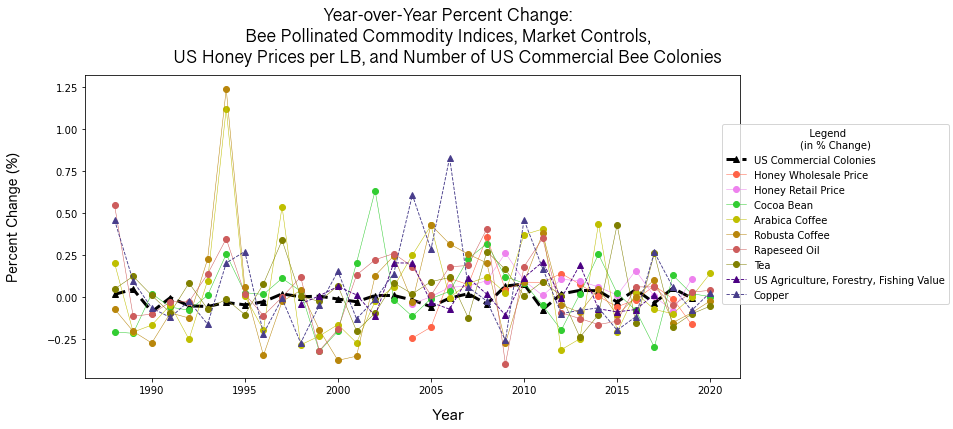

In [41]:
#######Purpose: plot all commodities on one plot with US commercial colonies in percent change. Pick out some interesting trends to further explore

fig, ax = plt.subplots(figsize=(14,6))
fig.suptitle("Year-over-Year Percent Change:\nBee Pollinated Commodity Indices, Market Controls,\nUS Honey Prices per LB, and Number of US Commercial Bee Colonies", size = 18.5, fontname="Myanmar Sangam MN")
# fig.subplots_adjust(top=0.88)

l1 = ax.plot(finalmergedf.index,finalmergedf["PCT Change: Colonies"], "k^--", linewidth=3);
####This is the main line of comparison for all other trend lines. That is why it is black, line thickness of 3, and triangle points on a dashed line

l2 = ax.plot(finalmergedf.index, finalmergedf["PCT Change: Honey Wholesale Price"], "o-", color = "tomato", linewidth = 0.5);

l3 = ax.plot(finalmergedf.index, finalmergedf["PCT Change: Honey Retail Price"],"o-", color = "violet", linewidth=0.5);

l4 = ax.plot(finalmergedf.index,finalmergedf["PCT Change: Cocoa Bean"], "o-", color="limegreen", linewidth=0.5);

l5 = ax.plot(finalmergedf.index,finalmergedf["PCT Change: Arabica Coffee"], "o-", color="y", linewidth=0.5); #### Arabica and Robusta coffee are similar but not the same color

l6 = ax.plot(finalmergedf.index,finalmergedf["PCT Change: Robusta Coffee"], "o-", color="darkgoldenrod", linewidth=0.5); ####Arabica and Robusta coffee are similar but not the same color

l7 = ax.plot(finalmergedf.index,finalmergedf["PCT Change: Rapeseed Oil"], "o-", color="indianred", linewidth=0.5); ####Arabica and Robusta coffee are similar but not the same color

l8 =  ax.plot(finalmergedf.index,finalmergedf["PCT Change: Tea"], "o-", color="olive", linewidth=0.5); ####Tea


l9 = ax.plot(finalmergedf.index, finalmergedf["PCT Change: US Agriculture, Forestry, Fishing Value in USD"], "^--", color="indigo", linewidth=0.9); ###This is a market control for the overall trends of agriculture, forestry, and fishery; has 0.4 more line thickness;
##...is a darker color trend line, and has triangles for points on a dashed line to denote a control

l10 = ax.plot(finalmergedf.index,finalmergedf["PCT Change: Copper"], "^--", color="darkslateblue", linewidth=0.9); ###




fig.subplots_adjust(bottom = .12, top = 0.82, right = 0.79, left = 0.14, wspace=0.3, hspace=0.7)

fig.text(0.5, 0.025, 'Year', ha='center', size = 14.5, fontname="Hiragino Maru Gothic Pro"); ###Set common x-label: year

fig.text(0.07, 0.35, 'Percent Change (%)', ha='center', size = 13.2, rotation='vertical', fontname="Hiragino Maru Gothic Pro"); ###Set common y-label: percent change (%)

fig.legend([ax], labels=["US Commercial Colonies", "Honey Wholesale Price","Honey Retail Price", "Cocoa Bean", "Arabica Coffee", "Robusta Coffee" , "Rapeseed Oil", "Tea", "US Agriculture, Forestry, Fishing Value", "Copper" ] ,loc="center right", borderaxespad=0.5, title="   Legend\n(in % Change)");

plt.savefig("FinalGraph1.PNG")


           


<ipython-input-42-3808d796f437>:103: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([ax], labels=["US Commercial Colonies", "US Agriculture, Forestry, Fishing Value", "Copper","US Commercial Colonies", "Honey Wholesale Price","Honey Retail Price", "US Commercial Colonies", "Cocoa Bean", "US Commercial Colonies", "Arabica Coffee", "Robusta Coffee" , "US Commercial Colonies", "Rapeseed Oil", "US Commercial Colonies", "Tea" ] ,loc="upper right", borderaxespad=0.5, fontsize = 14);


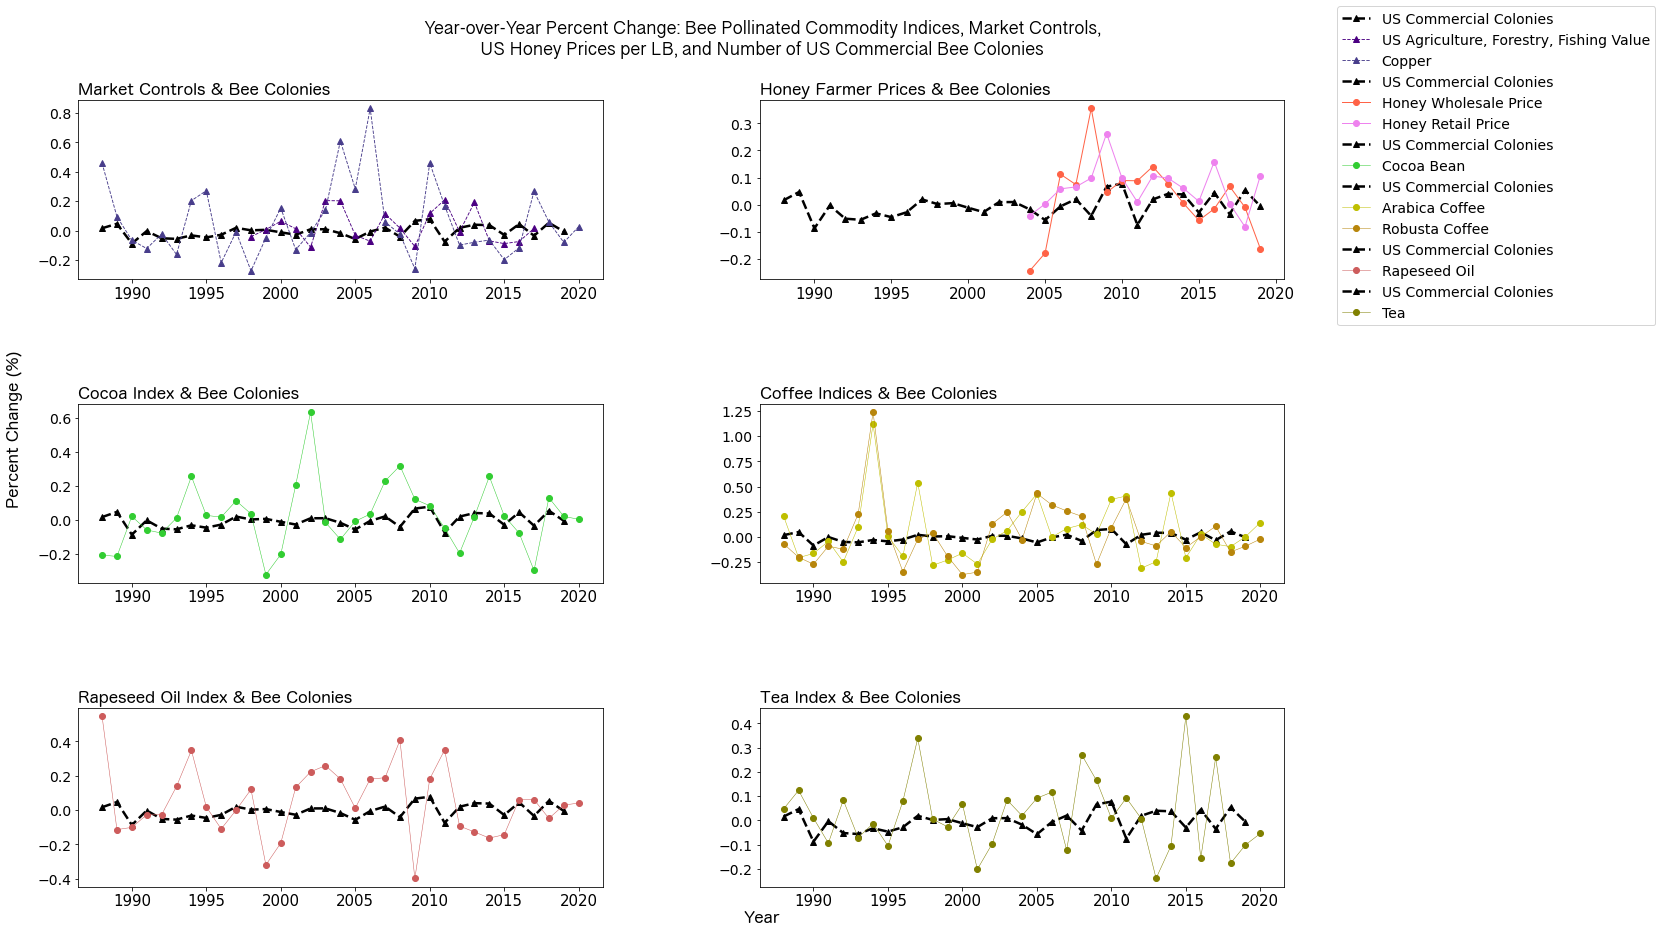

In [42]:
############Purpose: the above graph is too cluttered to make meaningful analysis, so let's break it down!
###########Making Separate Plots
#####All graphs have common x-axis title: Year, and common y-axis title: Percent Change (%)

######set figure, set overarching title
fig, ax = plt.subplots(figsize=(25,14))
fig.suptitle("Year-over-Year Percent Change: Bee Pollinated Commodity Indices, Market Controls,\nUS Honey Prices per LB, and Number of US Commercial Bee Colonies", size = 19, fontname="Myanmar Sangam MN")


################## Market Controls V. Colonies (PCT Change)
ax1 = plt.subplot(321)
L1= ax1.plot(finalmergedf.index, finalmergedf["PCT Change: Colonies"], "k^--", linewidth=2.5);
L2 =ax1.plot(finalmergedf.index, finalmergedf["PCT Change: US Agriculture, Forestry, Fishing Value in USD"], "^--", color="indigo", linewidth=0.9); 
L3=ax1.plot(finalmergedf.index,finalmergedf["PCT Change: Copper"], "^--", color="darkslateblue", linewidth=0.9); 
ax1.set_title("Market Controls & Bee Colonies", size = 16, fontname = "Hiragino Maru Gothic Pro", loc ="left")
##^^ set ax1's title
plt.xticks(fontsize = 15);

plt.yticks(fontsize = 14);

##################Honey V. Colonies

ax2 = plt.subplot(322)

L4 = ax2.plot(finalmergedf.index, finalmergedf["PCT Change: Colonies"], "k^--", linewidth=2.5);

L5 = ax2.plot(finalmergedf.index, finalmergedf["PCT Change: Honey Wholesale Price"], "o-", color = "tomato", linewidth=1);

L6 = ax2.plot(finalmergedf.index, finalmergedf["PCT Change: Honey Retail Price"],"o-", color = "violet", linewidth=1);


ax2.set_title("Honey Farmer Prices & Bee Colonies", size = 16, fontname = "Hiragino Maru Gothic Pro", loc ="left")

plt.xticks(fontsize = 15);

plt.yticks(fontsize = 14);




##################Cocoa V. Colonies
ax3 = plt.subplot(323)
L7 = ax3.plot(finalmergedf.index, finalmergedf["PCT Change: Colonies"], "k^--", linewidth=2.5);

L8 = ax3.plot(finalmergedf.index,finalmergedf["PCT Change: Cocoa Bean"], "o-", color="limegreen", linewidth=0.5);

ax3.set_title("Cocoa Index & Bee Colonies", size = 16, fontname = "Hiragino Maru Gothic Pro", loc ="left")

plt.xticks(fontsize = 15);

plt.yticks(fontsize = 14);

##################Coffee V. Colonies
ax4 = plt.subplot(324)
L9 = ax4.plot(finalmergedf.index, finalmergedf["PCT Change: Colonies"], "k^--", linewidth=2.5);
L10 = ax4.plot(finalmergedf.index,finalmergedf["PCT Change: Arabica Coffee"], "o-", color="y", linewidth=0.5); #### Arabica and Robusta coffee are similar but not the same color

L11 = ax4.plot(finalmergedf.index,finalmergedf["PCT Change: Robusta Coffee"], "o-", color="darkgoldenrod", linewidth=0.5); ####Arabica and Robusta coffee are similar but not the same color


ax4.set_title("Coffee Indices & Bee Colonies", size = 16, fontname = "Hiragino Maru Gothic Pro", loc ="left")
plt.xticks(fontsize = 15);

plt.yticks(fontsize = 14);


##################Rapeseed V. Colonies
ax5 = plt.subplot(325)
L12 = ax5.plot(finalmergedf.index, finalmergedf["PCT Change: Colonies"], "k^--", linewidth=2.5);

L13= ax5.plot(finalmergedf.index,finalmergedf["PCT Change: Rapeseed Oil"], "o-", color="indianred", linewidth=0.5);


ax5.set_title("Rapeseed Oil Index & Bee Colonies", size = 16, fontname = "Hiragino Maru Gothic Pro", loc ="left")

plt.xticks(fontsize = 15);

plt.yticks(fontsize = 14);
#################Tea V. Colonies
ax6 = plt.subplot(326)
L14=ax6.plot(finalmergedf.index, finalmergedf["PCT Change: Colonies"], "k^--", linewidth=2.5);

L15 = ax6.plot(finalmergedf.index,finalmergedf["PCT Change: Tea"], "o-", color="olive", linewidth=0.5);


ax6.set_title("Tea Index & Bee Colonies", size = 16, fontname = "Hiragino Maru Gothic Pro", loc ="left");

plt.xticks(fontsize = 15);

plt.yticks(fontsize = 14);



########################## General, Overall Graph Info
fig.subplots_adjust(bottom = .12, top = 0.9, right = 0.79, left = 0.12, wspace=0.3, hspace=0.7)
###^^this is explained in the final report


fig.text(0.5, 0.085, 'Year', ha='center', size = 16, fontname="Hiragino Maru Gothic Pro"); ###Set common x-label: year

fig.text(0.085, 0.5, 'Percent Change (%)', ha='center', size = 16, rotation='vertical', fontname="Hiragino Maru Gothic Pro"); ###Set common y-label: percent change (%)

fig.legend([ax], labels=["US Commercial Colonies", "US Agriculture, Forestry, Fishing Value", "Copper","US Commercial Colonies", "Honey Wholesale Price","Honey Retail Price", "US Commercial Colonies", "Cocoa Bean", "US Commercial Colonies", "Arabica Coffee", "Robusta Coffee" , "US Commercial Colonies", "Rapeseed Oil", "US Commercial Colonies", "Tea" ] ,loc="upper right", borderaxespad=0.5, fontsize = 14);


plt.savefig("FinalGraph2.PNG")




###Reference:####
#####references: http://www.learningaboutelectronics.com/Articles/How-to-change-the-line-width-of-a-graph-plot-in-matplotlib-with-Python.php
#####references: https://stackoverflow.com/questions/15858192/how-to-set-xlim-and-ylim-for-a-subplot-in-matplotlib
#####references: https://www.dataquest.io/blog/making-538-plots/
#####references: https://matplotlib.org/3.1.1/gallery/subplots_axes_and_figures/figure_title.html
#####references: https://stackoverflow.com/questions/18962063/matplotlib-setting-title-bold-while-using-times-new-roman
####references: http://jonathansoma.com/lede/data-studio/matplotlib/list-all-fonts-available-in-matplotlib-plus-samples/
####references: https://stackoverflow.com/questions/7066121/how-to-set-a-single-main-title-above-all-the-subplots-with-pyplot
####references: https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.set_title.html
####references: https://stackoverflow.com/questions/16150819/common-xlabel-ylabel-for-matplotlib-subplots
####references: https://matplotlib.org/examples/color/named_colors.html






<ipython-input-43-6ddd350a1585>:234: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([ax], labels=[ "US Commercial Colonies", "US Agriculture, Forestry, Fishing Value", "Copper","US Commercial Colonies","Honey Wholesale Price","Honey Retail Price", "Cocoa Bean", "US Commercial Colonies","Arabica Coffee", "Robusta Coffee" , "US Commercial Colonies","Rapeseed Oil", "Tea" ], loc="upper right", borderaxespad=0.5, fontsize = 14);
<ipython-input-43-6ddd350a1585>:237: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.subplots_adjust(bottom = .12, top = 0.9, right = 0.8, left = 0.12, wspace=0.3, hspace=0.7)


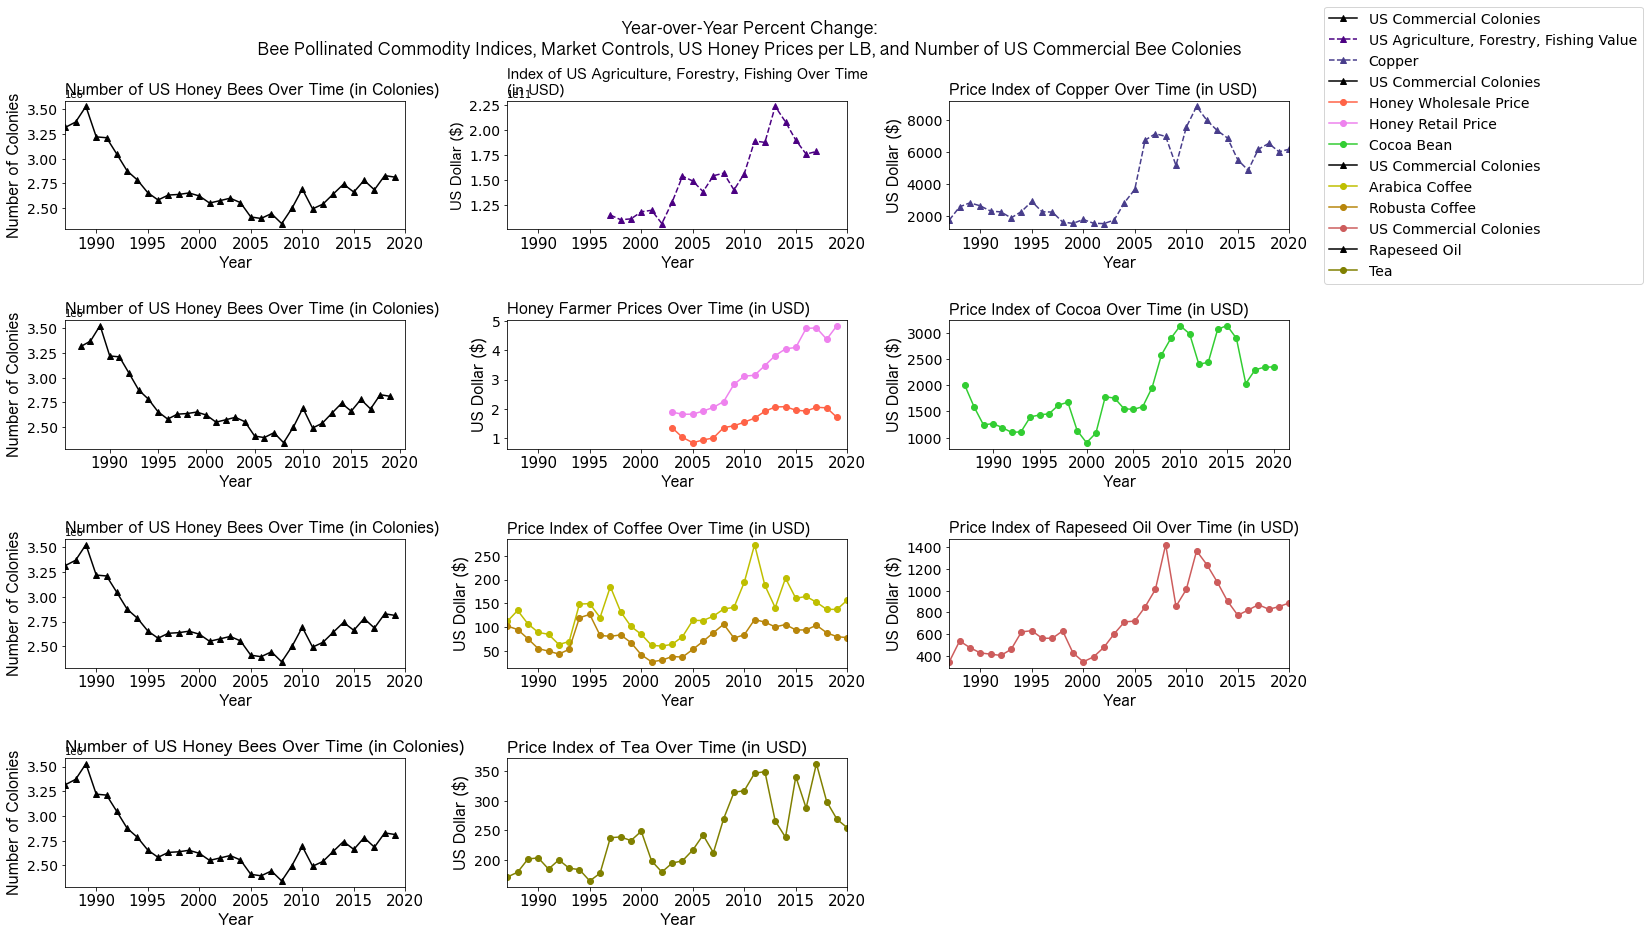

In [43]:
##plot out controls side-by-side with the commodity price index ($) with the US Commercial Colonies on a separate graph (since different units). Do not include honey since it is retail and whole sale prices which is different than an index, which takes market factors into account more.
###^^explanation reference: https://www.investopedia.com/terms/i/index.asp

############Purpose: the above graph is too cluttered to make meaningful analysis, so let's break it down!
###########Making Separate Plots
#####All graphs have common x-axis title: Year, and common y-axis title: Percent Change (%)

fig, ax = plt.subplots(constrained_layout=True, figsize=(25,14))
fig.suptitle("Year-over-Year Percent Change:\nBee Pollinated Commodity Indices, Market Controls, US Honey Prices per LB, and Number of US Commercial Bee Colonies", size = 19, fontname="Myanmar Sangam MN")
# fig.subplots_adjust(top=0.88)



########from ax1 onward, every three ax represents bee colony data to compare with commodity(ies) index(es). Appears on left of the graphs from row 2 onwards
ax1 = plt.subplot(4,3,1)
ax1.set_xlim(left = 1987, right = 2020)
n1 = ax1.plot(finalmergedf.index, finalmergedf["HONEY, BEE COLONIES - INVENTORY, MEASURED IN COLONIES"], "^-k"); 

ax1.set_title("Number of US Honey Bees Over Time (in Colonies)", size = 15, fontname = "Hiragino Maru Gothic Pro", loc ="left");

plt.xticks(fontsize = 15);

plt.yticks(fontsize = 14);
ax1.set_ylabel('Number of Colonies', rotation='vertical', fontname="Hiragino Maru Gothic Pro", fontsize=15); ###Set common y-label: percent change (%))
ax1.set_xlabel('Year', fontname="Hiragino Maru Gothic Pro", fontsize=15); ###Set common y-label: percent change (%))




################## Controls on top of row of graphs
ax2 = plt.subplot(4,3,2)
ax2.set_xlim(left = 1987, right = 2020) ###This fixes a strange error where the xaxis displays as floats with decimal points (e.g. 1990.5)
n2 = ax2.plot(finalmergedf.index, finalmergedf["US Agr,Fo,Fi Index in Dollars"], "^--", color="indigo"); 
ax2.set_title("Index of US Agriculture, Forestry, Fishing Over Time\n(in USD)", size = 14, fontname = "Hiragino Maru Gothic Pro", loc ="left");
ax2.set_ylabel('US Dollar ($)', rotation='vertical', fontname="Hiragino Maru Gothic Pro", fontsize=14); ###Set common y-label: percent change (%))
ax2.set_xlabel('Year',  fontname="Hiragino Maru Gothic Pro", fontsize=15); ###Set common y-label: percent change (%))




plt.xticks(fontsize = 15);

plt.yticks(fontsize = 14);

######Copper 
ax3 = plt.subplot(4,3,3)
ax3.set_xlim(left = 1987, right = 2020)
n3 = ax3.plot(finalmergedf.index,finalmergedf["Copper in USD"], "^--", color="darkslateblue"); 
ax3.set_title("Price Index of Copper Over Time (in USD)", size = 15, fontname = "Hiragino Maru Gothic Pro", loc ="left");
ax3.set_ylabel('US Dollar ($)', rotation='vertical', fontname="Hiragino Maru Gothic Pro", fontsize=15); ###Set common y-label: percent change (%))
ax3.set_xlabel('Year',  fontname="Hiragino Maru Gothic Pro", fontsize=15); ###Set common y-label: percent change (%))





plt.xticks(fontsize = 15);

plt.yticks(fontsize = 14);



########from ax1 onward, every three ax represents bee colony data to compare with commodity(ies) index(es). Appears on left of the graphs from row 2 onwards


ax4 = plt.subplot(4,3,4)
n4 = ax4.plot(finalmergedf.index, finalmergedf["HONEY, BEE COLONIES - INVENTORY, MEASURED IN COLONIES"], "^-k"); 

ax4.set_title("Number of US Honey Bees Over Time (in Colonies)", size = 15, fontname = "Hiragino Maru Gothic Pro", loc ="left");

plt.xticks(fontsize = 15);

plt.yticks(fontsize = 14);

ax4.set_ylabel('Number of Colonies', rotation='vertical', fontname="Hiragino Maru Gothic Pro", fontsize=15); ###Set common y-label: percent change (%))

ax4.set_xlabel('Year',  fontname="Hiragino Maru Gothic Pro", fontsize=15); ###Set common y-label: percent change (%))








# ##################Honey Wholesale and Retail on one graph -- both are honey related and have similar price index values


ax5 = plt.subplot(4,3,5)
ax5.set_xlim(left = 1987, right = 2020)
n51=ax5.plot(finalmergedf.index,finalmergedf["HONEY, WHOLESALE - PRICE RECEIVED, MEASURED IN $ / LB"], "o-", color="tomato");
n52=ax5.plot(finalmergedf.index,finalmergedf["HONEY, RETAIL - PRICE RECEIVED, MEASURED IN $ / LB"], "o-", color="violet");
ax5.set_title("Honey Farmer Prices Over Time (in USD)" , size = 15, fontname = "Hiragino Maru Gothic Pro", loc ="left");

ax5.set_ylabel('US Dollar ($)', rotation='vertical', fontname="Hiragino Maru Gothic Pro", fontsize=15); ###Set common y-label: percent change (%))

ax5.set_xlabel('Year', fontname="Hiragino Maru Gothic Pro", fontsize=15); ###Set common y-label: percent change (%))



####Cocoa beans

plt.xticks(fontsize = 15)

plt.yticks(fontsize = 14)

ax6 = plt.subplot(4,3,6)
n6=ax6.plot(finalmergedf.index,finalmergedf["Cocoa Beans in USD"], "o-", color="limegreen");

ax6.set_title("Price Index of Cocoa Over Time (in USD)", size = 15, fontname = "Hiragino Maru Gothic Pro", loc ="left")

ax6.set_ylabel('US Dollar ($)', rotation='vertical', fontname="Hiragino Maru Gothic Pro", fontsize=15); ###Set common y-label: percent change (%))
ax6.set_xlabel('Year', fontname="Hiragino Maru Gothic Pro", fontsize=15); ###Set common y-label: percent change (%))

  


plt.xticks(fontsize = 15)

plt.yticks(fontsize = 14)



########from ax1 onward, every three ax represents bee colony data to compare with commodity(ies) index(es). Appears on left of the graphs from row 2 onwards

ax7 = plt.subplot(4,3,7)
ax7.set_xlim(left = 1987, right = 2020)
n7 = ax7.plot(finalmergedf.index, finalmergedf["HONEY, BEE COLONIES - INVENTORY, MEASURED IN COLONIES"], "^-k"); 

ax7.set_title("Number of US Honey Bees Over Time (in Colonies)", size = 15, fontname = "Hiragino Maru Gothic Pro", loc ="left");

ax7.set_ylabel('Number of Colonies', rotation='vertical', fontname="Hiragino Maru Gothic Pro", fontsize=15); ###Set common y-label: percent change (%))
ax7.set_xlabel('Year',  fontname="Hiragino Maru Gothic Pro", fontsize=15); ###Set common y-label: percent change (%))




plt.xticks(fontsize = 15);

plt.yticks(fontsize = 14);



# ##################Coffee Robusta and Arabica on one graph -- both are honey related and have similar price index values



ax8 = plt.subplot(4,3,8)
ax8.set_xlim(left = 1987, right = 2020)
n81=ax8.plot(finalmergedf.index,finalmergedf["Arabica Coffee in USD"], "o-", color="y");
n82=ax8.plot(finalmergedf.index,finalmergedf["Robusta Coffee in USD"], "o-", color="darkgoldenrod");

ax8.set_title("Price Index of Coffee Over Time (in USD)", size = 15, fontname = "Hiragino Maru Gothic Pro", loc ="left")

ax8.set_ylabel('US Dollar ($)', rotation='vertical', fontname="Hiragino Maru Gothic Pro", fontsize=15); ###Set common y-label: percent change (%))
ax8.set_xlabel('Year', fontname="Hiragino Maru Gothic Pro", fontsize=15); ###Set common y-label: percent change (%))






plt.xticks(fontsize = 15)

plt.yticks(fontsize = 14)


#####Rapeseed Oil
ax9 = plt.subplot(4,3,9)
ax9.set_xlim(left = 1987, right = 2020)
n9=ax9.plot(finalmergedf.index,finalmergedf["Rapeseed Oil in USD"], "o-", color="indianred");

ax9.set_title("Price Index of Rapeseed Oil Over Time (in USD)", size = 15, fontname = "Hiragino Maru Gothic Pro", loc ="left");

ax9.set_ylabel('US Dollar ($)', rotation='vertical', fontname="Hiragino Maru Gothic Pro", fontsize=15); ###Set common y-label: percent change (%))
ax9.set_xlabel('Year', fontname="Hiragino Maru Gothic Pro", fontsize=15); ###Set common y-label: percent change (%))






plt.xticks(fontsize = 15)

plt.yticks(fontsize = 14)






########from ax1 onward, every three ax represents bee colony data to compare with commodity(ies) index(es). Appears on left of the graphs from row 2 onwards

ax10 = plt.subplot(4,3,10)
ax10.set_xlim(left = 1987, right = 2020)
n10 = ax10.plot(finalmergedf.index, finalmergedf["HONEY, BEE COLONIES - INVENTORY, MEASURED IN COLONIES"], "^-k"); 

ax10.set_title("Number of US Honey Bees Over Time (in Colonies)", size = 16, fontname = "Hiragino Maru Gothic Pro", loc ="left");

ax10.set_ylabel('Number of Colonies', rotation='vertical', fontname="Hiragino Maru Gothic Pro", fontsize=15); ###Set common y-label: percent change (%))

ax10.set_xlabel('Year', fontname="Hiragino Maru Gothic Pro", fontsize=16); ###Set common y-label: percent change (%))




plt.xticks(fontsize = 15);

plt.yticks(fontsize = 14);



############Tea
ax11 = plt.subplot(4,3,11)
ax11.set_xlim(left = 1987, right = 2020)
n11=ax11.plot(finalmergedf.index,finalmergedf["Tea in USD"], "o-", color="olive");

ax11.set_title("Price Index of Tea Over Time (in USD)", size = 16, fontname = "Hiragino Maru Gothic Pro", loc ="left")
ax11.set_ylabel('US Dollar ($)', rotation='vertical', fontname="Hiragino Maru Gothic Pro", fontsize=15); ###Set common y-label: percent change (%))
ax11.set_xlabel('Year', fontname="Hiragino Maru Gothic Pro", fontsize=16); ###Set common y-label: percent change (%))





plt.xticks(fontsize = 15)

plt.yticks(fontsize = 14)



# ########################## General, Overall Graph Info

fig.legend([ax], labels=[ "US Commercial Colonies", "US Agriculture, Forestry, Fishing Value", "Copper","US Commercial Colonies","Honey Wholesale Price","Honey Retail Price", "Cocoa Bean", "US Commercial Colonies","Arabica Coffee", "Robusta Coffee" , "US Commercial Colonies","Rapeseed Oil", "Tea" ], loc="upper right", borderaxespad=0.5, fontsize = 14);


fig.subplots_adjust(bottom = .12, top = 0.9, right = 0.8, left = 0.12, wspace=0.3, hspace=0.7)




plt.savefig("FinalGraph3.PNG", dpi=100)






################ Reference: ######################
##########references: https://matplotlib.org/3.2.1/tutorials/intermediate/constrainedlayout_guide.html
##########references: https://matplotlib.org/3.2.1/gallery/subplots_axes_and_figures/subplots_demo.html
#####references: http://www.learningaboutelectronics.com/Articles/How-to-change-the-line-width-of-a-graph-plot-in-matplotlib-with-Python.php
#####references: https://stackoverflow.com/questions/15858192/how-to-set-xlim-and-ylim-for-a-subplot-in-matplotlib
#####references: https://www.dataquest.io/blog/making-538-plots/
#####references: https://matplotlib.org/3.1.1/gallery/subplots_axes_and_figures/figure_title.html
#####references: https://stackoverflow.com/questions/18962063/matplotlib-setting-title-bold-while-using-times-new-roman
####references: http://jonathansoma.com/lede/data-studio/matplotlib/list-all-fonts-available-in-matplotlib-plus-samples/
####references: https://stackoverflow.com/questions/7066121/how-to-set-a-single-main-title-above-all-the-subplots-with-pyplot
####references: https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.set_title.html
####references: https://stackoverflow.com/questions/16150819/common-xlabel-ylabel-for-matplotlib-subplots
####references: https://matplotlib.org/examples/color/named_colors.html


#### Average Percent Change Over Time Year-Over-Year 
(Referenced in Report Analysis and Visualizations Section)

In [44]:
#####Bees in Colonies

finalmergedf["PCT Change: Colonies"].mean()

-0.004309619114363658

In [45]:
#Control 1
finalmergedf["PCT Change: US Agriculture, Forestry, Fishing Value in USD"].mean()

0.027834557860094665

In [46]:
#Control 2
finalmergedf["PCT Change: Copper"].mean()



0.06407968699932098

In [47]:
#Honey Wholesale
finalmergedf["PCT Change: Honey Wholesale Price"].mean()

0.024110767990350723

In [48]:
#Honey Retail
finalmergedf["PCT Change: Honey Retail Price"].mean()

0.0637483224272728

In [49]:
##Cocoa
finalmergedf["PCT Change: Cocoa Bean"].mean()

0.021473906934261322

In [50]:
###Wholesale
finalmergedf["PCT Change: Honey Wholesale Price"].mean()

0.024110767990350723

In [51]:
####Arabica
finalmergedf["PCT Change: Arabica Coffee"].mean()

0.04634341225028038

In [52]:
####Robusta

finalmergedf["PCT Change: Robusta Coffee"].mean()

0.02704450488090515

In [53]:
#####Rapeseed

finalmergedf["PCT Change: Rapeseed Oil"].mean()

0.04885726049542427

In [54]:
#####Tea

finalmergedf["PCT Change: Tea"].mean()

0.022796552628278732